# Transformers Pipeline Exploration

**Reference**: [HuggingFace LLM Course — Chapter 1.3](https://huggingface.co/learn/llm-course/chapter1/3)  
**Design doc**: [docs/transformers_pipeline_experiment.md](../docs/transformers_pipeline_experiment.md)

This notebook walks through all 10 `pipeline()` task types taught in the HuggingFace LLM Course,
systematically benchmarking each one and exploring ablation studies.

## The 3-Stage Pipeline Architecture

```
Input (text / image / audio)
        │
        ▼
  Preprocessing   ← Tokenizer / Feature Extractor
        │
        ▼
   Model Forward  ← AutoModel (logits)
        │
        ▼
 Postprocessing   ← Decode, softmax, format
        │
        ▼
Output (human-readable dict)
```

## Task Inventory

| # | Task | Pipeline | Architecture |
|---|------|----------|--------------|
| 1 | Sentiment analysis | `text-classification` | Encoder-only |
| 2 | Zero-shot classification | `zero-shot-classification` | Encoder-decoder |
| 3 | Text generation | `text-generation` | Decoder-only |
| 4 | Mask filling | `fill-mask` | Encoder-only |
| 5 | Named entity recognition | `ner` | Encoder-only |
| 6 | Question answering | `question-answering` | Encoder-only |
| 7 | Summarization | `summarization` | Encoder-decoder |
| 8 | Translation | `translation` | Encoder-decoder |
| 9 | Image classification | `image-classification` | Vision Transformer |
| 10 | Speech recognition | `automatic-speech-recognition` | Encoder-decoder |

> **Note**: First run downloads models (~10 GB total). Subsequent runs use the local cache.

## Setup

In [ ]:
import json
import os
import sys
import time
from pathlib import Path

import torch
from dotenv import load_dotenv
from IPython.display import display

# Load .env from project root (sets HF_TOKEN, etc.)
load_dotenv(Path.cwd().parent / ".env")

# Ensure project root is on the path so `src.pipeline_exploration` is importable
sys.path.insert(0, str(Path.cwd().parent))

# Detect device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

if os.environ.get("HF_TOKEN"):
    print("HF_TOKEN: loaded")
else:
    print("HF_TOKEN: not set (some gated models may be unavailable)")

In [67]:
# Helper: pretty-print results
def show(title, data, indent=2):
    print(f"\n{'─' * 60}")
    print(f"  {title}")
    print(f"{'─' * 60}")
    print(json.dumps(data, indent=indent, default=str, ensure_ascii=False))

# Collect benchmarks for the final comparison table
benchmark_log: list[dict] = []

---
## Experiment 1 — Text Classification (Sentiment Analysis)

**Pipeline**: `text-classification`  
**Model**: `distilbert-base-uncased-finetuned-sst-2-english`  
**Architecture**: Encoder-only (DistilBERT fine-tuned on SST-2)

The model assigns a label (`POSITIVE` / `NEGATIVE`) and a confidence score to each text.

In [68]:
from transformers import pipeline

# --- Load ---
classifier = pipeline("text-classification", device=DEVICE)

# --- Course examples ---
course_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
course_outputs = classifier(course_inputs)
show("Course examples", dict(zip(course_inputs, course_outputs)))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f.
Using a pipeline without specifying a model name and revision in production is not recommended.
Loading weights: 100%|██████████| 104/104 [00:00<00:00, 389.71it/s, Materializing param=pre_classifier.weight]                                  



────────────────────────────────────────────────────────────
  Course examples
────────────────────────────────────────────────────────────
{
  "I've been waiting for a HuggingFace course my whole life.": {
    "label": "POSITIVE",
    "score": 0.9598047137260437
  },
  "I hate this so much!": {
    "label": "NEGATIVE",
    "score": 0.9994558691978455
  }
}


In [69]:
# --- Edge cases ---
edge_cases = {
    "neutral": "The weather is somewhat acceptable today.",
    "non_english": "Je suis très heureux d'être ici.",
    "single_word": "Excellent!",
}
for name, text in edge_cases.items():
    result = classifier(text)[0]
    print(f"{name:15s} → {result['label']:8s} ({result['score']:.4f}) | {text!r}")

neutral         → POSITIVE (0.9991) | 'The weather is somewhat acceptable today.'
non_english     → NEGATIVE (0.8803) | "Je suis très heureux d'être ici."
single_word     → POSITIVE (0.9999) | 'Excellent!'


In [70]:
# --- Benchmark ---
_ = classifier(course_inputs[0])  # warm-up
times = []
for _ in range(10):
    t0 = time.perf_counter()
    classifier(course_inputs[0])
    times.append((time.perf_counter() - t0) * 1000)

bm = {"task": "text-classification", "model": "distilbert-sst2",
      "warm_latency_ms": round(sum(times) / len(times), 1)}
benchmark_log.append(bm)
print(f"Warm latency (mean of 10): {bm['warm_latency_ms']} ms")

Warm latency (mean of 10): 6.9 ms


---
## Experiment 2 — Zero-Shot Classification

**Pipeline**: `zero-shot-classification`  
**Model**: `facebook/bart-large-mnli`  
**Architecture**: Encoder-decoder (BART trained on MNLI)

Classify text into arbitrary labels **without any task-specific fine-tuning**.
Uses Natural Language Inference (NLI): is the text entailed by each candidate label?

### Ablation: Label Count Scaling
How does inference time scale with the number of candidate labels?

In [71]:
zero_shot = pipeline("zero-shot-classification", device=DEVICE)

# --- Course example ---
sequence = "This is a course about the Transformers library"
labels = ["education", "politics", "business"]
result = zero_shot(sequence, candidate_labels=labels)
show("Course example", {l: round(s, 4) for l, s in zip(result["labels"], result["scores"])})

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1.
Using a pipeline without specifying a model name and revision in production is not recommended.
Loading weights: 100%|██████████| 515/515 [00:01<00:00, 419.62it/s, Materializing param=model.shared.weight]                                   



────────────────────────────────────────────────────────────
  Course example
────────────────────────────────────────────────────────────
{
  "education": 0.8446,
  "business": 0.112,
  "politics": 0.0434
}


In [72]:
# --- Ablation: label count scaling ---
label_pool = ["education", "politics", "business", "technology", "science",
              "sports", "entertainment", "health", "environment", "culture"]

print(f"{'n_labels':>10} | {'latency (ms)':>14} | top label")
print("-" * 45)
for n in [2, 3, 5, 10]:
    sub_labels = label_pool[:n]
    # warm-up
    zero_shot(sequence, candidate_labels=sub_labels)
    t0 = time.perf_counter()
    out = zero_shot(sequence, candidate_labels=sub_labels)
    ms = (time.perf_counter() - t0) * 1000
    print(f"{n:>10} | {ms:>14.1f} | {out['labels'][0]}")

  n_labels |   latency (ms) | top label
---------------------------------------------
         2 |           52.6 | education
         3 |           79.2 | education
         5 |          129.8 | technology
        10 |          259.5 | technology


In [73]:
# Benchmark (3 labels)
_ = zero_shot(sequence, candidate_labels=labels)  # warm-up
times = []
for _ in range(5):
    t0 = time.perf_counter()
    zero_shot(sequence, candidate_labels=labels)
    times.append((time.perf_counter() - t0) * 1000)

bm = {"task": "zero-shot-classification", "model": "bart-large-mnli",
      "warm_latency_ms": round(sum(times) / len(times), 1)}
benchmark_log.append(bm)
print(f"Warm latency (mean of 5, 3 labels): {bm['warm_latency_ms']} ms")

Warm latency (mean of 5, 3 labels): 78.4 ms


---
## Experiment 3 — Text Generation

**Pipeline**: `text-generation`  
**Default model**: `openai-community/gpt2` (GPT-2)  
**Architecture**: Decoder-only autoregressive LM

### Ablations
1. **Temperature sweep** — {0.7, 1.0, 1.5}: lower = more focused, higher = more creative  
2. **Model comparison** — GPT-2 vs SmolLM2-360M

In [74]:
generator = pipeline("text-generation", model="openai-community/gpt2", device=DEVICE)

# --- Course example ---
prompt = "In this course, we will teach you how to"
output = generator(prompt, max_new_tokens=50, num_return_sequences=1)
print(f"Prompt : {prompt!r}")
print(f"Output : {output[0]['generated_text']!r}")

Loading weights: 100%|██████████| 148/148 [00:00<00:00, 410.21it/s, Materializing param=transformer.wte.weight]             
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=50) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt : 'In this course, we will teach you how to'
Output : 'In this course, we will teach you how to create a simple, high-quality app in PHP that you can easily use to create applications easily using C# and ASP. We will also give you a little sample application that will show you how to use Visual Studio 2015 to create small, responsive apps'


In [75]:
# --- Ablation: temperature sweep ---
print(f"Prompt: {prompt!r}\n")
for temp in [0.7, 1.0, 1.5]:
    out = generator(prompt, max_new_tokens=40, temperature=temp,
                    do_sample=True, num_return_sequences=1)
    text = out[0]["generated_text"][len(prompt):].strip()
    print(f"  temp={temp} → {text!r}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=40) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: 'In this course, we will teach you how to'



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=40) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  temp=0.7 → 'create a full-scale Web website using a simple and simple HTML page.\n\nThis course is part of the series on HTML, CSS, and JavaScript, released on September 27, 2016.'


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=40) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


  temp=1.0 → 'connect with the most influential leaders.\n\nIntroduction to Leadership\n\nFirst up, we will begin by introducing you to the fundamentals of leadership.\n\nLearn to understand what leaders are and can communicate'
  temp=1.5 → 'design your own web application development apps and we will learn how to build interactive environments when using Node.\n\nPlease check back soon to see more examples created by Sipak, and thanks For submitting'


In [76]:
# --- Ablation: model comparison ---
smol = pipeline("text-generation", model="HuggingFaceTB/SmolLM2-360M", device=DEVICE)
smol_out = smol(prompt, max_new_tokens=50, num_return_sequences=1)
gpt2_out = generator(prompt, max_new_tokens=50, num_return_sequences=1)

print("GPT-2     :", gpt2_out[0]["generated_text"])
print()
print("SmolLM2   :", smol_out[0]["generated_text"])

Loading weights: 100%|██████████| 290/290 [00:00<00:00, 433.40it/s, Materializing param=model.norm.weight]                              
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Both `max_new_tokens` (=50) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=50) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


GPT-2     : In this course, we will teach you how to write an automated query with Hibernate and how to create and manage Hibernate's Query Queue.

In this class you will learn how to create a Hibernate Hibernate Query Queue and how to

SmolLM2   : In this course, we will teach you how to use the internet in different ways, from the most common to the most uncommon.

For example, you will be able to access all the information you need instantly. You will be able to access the world’s most important information on almost any


In [77]:
# Benchmark
_ = generator(prompt, max_new_tokens=50)  # warm-up
times = []
for _ in range(5):
    t0 = time.perf_counter()
    generator(prompt, max_new_tokens=50)
    times.append((time.perf_counter() - t0) * 1000)

bm = {"task": "text-generation", "model": "gpt2",
      "warm_latency_ms": round(sum(times) / len(times), 1)}
benchmark_log.append(bm)
print(f"Warm latency (mean of 5, 50 new tokens): {bm['warm_latency_ms']} ms")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=50) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=50) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=50) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`

Warm latency (mean of 5, 50 new tokens): 631.9 ms


---
## Experiment 4 — Fill-Mask

**Pipeline**: `fill-mask`  
**Default model**: `distilroberta-base` (uses `<mask>` token)  
**Architecture**: Encoder-only MLM

### Ablation: mask token / model
- DistilRoBERTa uses `<mask>` 
- BERT-base-cased uses `[MASK]`

In [78]:
unmasker = pipeline("fill-mask", device=DEVICE)  # default: distilroberta-base

# --- Course example ---
text = "This course will teach you all about <mask> models."
results = unmasker(text)
print(f"Input: {text!r}")
print("\nTop predictions:")
for r in results[:5]:
    print(f"  {r['token_str']:15s} → score={r['score']:.4f} | {r['sequence']!r}")

No model was supplied, defaulted to distilbert/distilroberta-base and revision fb53ab8.
Using a pipeline without specifying a model name and revision in production is not recommended.
Loading weights: 100%|██████████| 106/106 [00:00<00:00, 418.45it/s, Materializing param=roberta.encoder.layer.5.output.dense.weight]             
RobertaForMaskedLM LOAD REPORT from: distilbert/distilroberta-base
Key                         | Status     |  | 
----------------------------+------------+--+-
roberta.pooler.dense.weight | UNEXPECTED |  | 
roberta.pooler.dense.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Input: 'This course will teach you all about <mask> models.'

Top predictions:
   mathematical   → score=0.1962 | 'This course will teach you all about mathematical models.'
   computational  → score=0.0405 | 'This course will teach you all about computational models.'
   predictive     → score=0.0330 | 'This course will teach you all about predictive models.'
   building       → score=0.0319 | 'This course will teach you all about building models.'
   computer       → score=0.0245 | 'This course will teach you all about computer models.'


In [79]:
# --- Ablation: BERT-base-cased with [MASK] token ---
bert_unmasker = pipeline("fill-mask", model="bert-base-cased", device=DEVICE)
bert_text = "This course will teach you all about [MASK] models."
bert_results = bert_unmasker(bert_text)

print("DistilRoBERTa (<mask>):")
for r in results[:3]:
    print(f"  {r['token_str']:15s} score={r['score']:.4f}")

print("\nBERT-base-cased ([MASK]):")
for r in bert_results[:3]:
    print(f"  {r['token_str']:15s} score={r['score']:.4f}")

Loading weights: 100%|██████████| 202/202 [00:00<00:00, 416.54it/s, Materializing param=cls.predictions.transform.dense.weight]                 
BertForMaskedLM LOAD REPORT from: bert-base-cased
Key                         | Status     |  | 
----------------------------+------------+--+-
cls.seq_relationship.weight | UNEXPECTED |  | 
cls.seq_relationship.bias   | UNEXPECTED |  | 
bert.pooler.dense.bias      | UNEXPECTED |  | 
bert.pooler.dense.weight    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


DistilRoBERTa (<mask>):
   mathematical   score=0.1962
   computational  score=0.0405
   predictive     score=0.0330

BERT-base-cased ([MASK]):
  role            score=0.2596
  the             score=0.0943
  fashion         score=0.0339


In [80]:
# Benchmark
_ = unmasker(text)  # warm-up
times = []
for _ in range(10):
    t0 = time.perf_counter()
    unmasker(text)
    times.append((time.perf_counter() - t0) * 1000)

bm = {"task": "fill-mask", "model": "distilroberta-base",
      "warm_latency_ms": round(sum(times) / len(times), 1)}
benchmark_log.append(bm)
print(f"Warm latency (mean of 10): {bm['warm_latency_ms']} ms")

Warm latency (mean of 10): 9.9 ms


---
## Experiment 5 — Named Entity Recognition (NER)

**Pipeline**: `ner`  
**Model**: `dbmdz/bert-large-cased-finetuned-conll03-english`  
**Architecture**: Encoder-only (BERT-large with token classification head)

### Ablation: `aggregation_strategy`
- `"simple"` → merge subword tokens into whole words/spans  
- `"none"` → raw per-token predictions

In [81]:
ner = pipeline("ner", aggregation_strategy="simple", device=DEVICE)

# --- Course example ---
text = "My name is Sylvain and I work at Hugging Face in Brooklyn."
entities = ner(text)
show("Course example (aggregation_strategy='simple')", entities)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496.
Using a pipeline without specifying a model name and revision in production is not recommended.
Loading weights: 100%|██████████| 391/391 [00:00<00:00, 434.91it/s, Materializing param=classifier.weight]                                      
BertForTokenClassification LOAD REPORT from: dbmdz/bert-large-cased-finetuned-conll03-english
Key                      | Status     |  | 
-------------------------+------------+--+-
bert.pooler.dense.bias   | UNEXPECTED |  | 
bert.pooler.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



────────────────────────────────────────────────────────────
  Course example (aggregation_strategy='simple')
────────────────────────────────────────────────────────────
[
  {
    "entity_group": "PER",
    "score": "0.9981694",
    "word": "Sylvain",
    "start": 11,
    "end": 18
  },
  {
    "entity_group": "ORG",
    "score": "0.9796019",
    "word": "Hugging Face",
    "start": 33,
    "end": 45
  },
  {
    "entity_group": "LOC",
    "score": "0.9932106",
    "word": "Brooklyn",
    "start": 49,
    "end": 57
  }
]


In [82]:
# --- Ablation: aggregation_strategy simple vs none ---
ner_raw = pipeline("ner", aggregation_strategy="none", device=DEVICE)
raw_entities = ner_raw(text)

print(f"aggregation_strategy='simple' → {len(entities)} entities")
for e in entities:
    print(f"  [{e['entity_group']:3s}] {e['word']!r:20s} ({e['score']:.4f})")

print(f"\naggregation_strategy='none'  → {len(raw_entities)} tokens")
for e in raw_entities:
    print(f"  [{e['entity']:6s}] {e['word']!r:15s} ({e['score']:.4f})")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496.
Using a pipeline without specifying a model name and revision in production is not recommended.
Loading weights: 100%|██████████| 391/391 [00:00<00:00, 404.58it/s, Materializing param=classifier.weight]                                      
BertForTokenClassification LOAD REPORT from: dbmdz/bert-large-cased-finetuned-conll03-english
Key                      | Status     |  | 
-------------------------+------------+--+-
bert.pooler.dense.bias   | UNEXPECTED |  | 
bert.pooler.dense.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


aggregation_strategy='simple' → 3 entities
  [PER] 'Sylvain'            (0.9982)
  [ORG] 'Hugging Face'       (0.9796)
  [LOC] 'Brooklyn'           (0.9932)

aggregation_strategy='none'  → 8 tokens
  [I-PER ] 'S'             (0.9994)
  [I-PER ] '##yl'          (0.9982)
  [I-PER ] '##va'          (0.9959)
  [I-PER ] '##in'          (0.9992)
  [I-ORG ] 'Hu'            (0.9739)
  [I-ORG ] '##gging'       (0.9761)
  [I-ORG ] 'Face'          (0.9888)
  [I-LOC ] 'Brooklyn'      (0.9932)


In [83]:
# Benchmark
_ = ner(text)  # warm-up
times = []
for _ in range(10):
    t0 = time.perf_counter()
    ner(text)
    times.append((time.perf_counter() - t0) * 1000)

bm = {"task": "ner", "model": "bert-large-conll03",
      "warm_latency_ms": round(sum(times) / len(times), 1)}
benchmark_log.append(bm)
print(f"Warm latency (mean of 10): {bm['warm_latency_ms']} ms")

Warm latency (mean of 10): 24.4 ms


---
## Experiment 6 — Question Answering (Extractive QA)

**Pipeline**: `question-answering`  
**Model**: `distilbert-base-cased-distilled-squad`  
**Architecture**: Encoder-only (DistilBERT with span-extraction head)

Extracts the answer span directly from the provided context — no generation involved.

In [84]:
qa = pipeline("question-answering", device=DEVICE)

# --- Course example ---
result = qa(
    question="Where do I work?",
    context="My name is Sylvain and I work at Hugging Face in Brooklyn",
)
show("Course example", result)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5.
Using a pipeline without specifying a model name and revision in production is not recommended.
Loading weights: 100%|██████████| 102/102 [00:00<00:00, 417.04it/s, Materializing param=qa_outputs.weight]                                     



────────────────────────────────────────────────────────────
  Course example
────────────────────────────────────────────────────────────
{
  "score": 0.6949762105941772,
  "start": 33,
  "end": 45,
  "answer": "Hugging Face"
}


In [85]:
# --- Edge cases ---
qa_pairs = [
    {
        "name": "multi-sentence context",
        "question": "What is the capital of France?",
        "context": "France is a country in Western Europe. Its capital city is Paris. The Eiffel Tower is located there.",
    },
    {
        "name": "technical question",
        "question": "What does the pipeline() function do?",
        "context": "The pipeline() function in HuggingFace Transformers is the highest-level entry point for NLP tasks. It encapsulates preprocessing, model forward pass, and postprocessing in a single callable.",
    },
]

for item in qa_pairs:
    res = qa(question=item["question"], context=item["context"])
    print(f"[{item['name']}]")
    print(f"  Q: {item['question']}")
    print(f"  A: {res['answer']!r}  (score={res['score']:.4f}, span=[{res['start']}:{res['end']}])")
    print()

[multi-sentence context]
  Q: What is the capital of France?
  A: 'Paris'  (score=0.9898, span=[59:64])

[technical question]
  Q: What does the pipeline() function do?
  A: 'highest-level entry point for NLP tasks'  (score=0.0215, span=[59:98])



In [86]:
# Benchmark
bench_input = {"question": "Where do I work?",
               "context": "My name is Sylvain and I work at Hugging Face in Brooklyn"}
_ = qa(**bench_input)  # warm-up
times = []
for _ in range(10):
    t0 = time.perf_counter()
    qa(**bench_input)
    times.append((time.perf_counter() - t0) * 1000)

bm = {"task": "question-answering", "model": "distilbert-squad",
      "warm_latency_ms": round(sum(times) / len(times), 1)}
benchmark_log.append(bm)
print(f"Warm latency (mean of 10): {bm['warm_latency_ms']} ms")

Warm latency (mean of 10): 8.9 ms


---
## Experiment 7 — Summarization

**Pipeline**: `summarization`  
**Model**: `sshleifer/distilbart-cnn-12-6` (DistilBART-CNN)  
**Architecture**: Encoder-decoder (BART distilled on CNN/DM)

### Ablation: max_length
How does the summary quality change as we allow more output tokens?

In [87]:
summarizer = pipeline("text-generation", model="sshleifer/distilbart-cnn-12-6", device=DEVICE)

# --- Course example ---
article = (
    "America has changed dramatically during recent years. Not only has the number of "
    "graduates in traditional engineering disciplines such as mechanical, civil, "
    "electrical, chemical, and aeronautical engineering declined, but in most of "
    "the premier universities in the United States, many of the valedictorians "
    "and high-ranking students are girls. Increasingly, these students are "
    "particularly in programs such as health and medical related fields, "
    "including premedical programs, medicine, law, business, and computer "
    "sciences. For women, the attractiveness of these majors is that they "
    "offer the opportunity to combine intellectual rigor and career potential "
    "with an altruistic contribution to society. This particular article, "
    "however, is about another major -- the STEM fields, which stands for "
    "science, technology, engineering, and mathematics."
)

result = summarizer(article, max_length=130, min_length=30)
# Display result — key depends on how transformers maps this model
print("Summary:")
print(result[0])

Loading weights: 100%|██████████| 160/160 [00:00<00:00, 476.09it/s, Materializing param=model.decoder.layers.5.self_attn_layer_norm.weight]   
BartForCausalLM LOAD REPORT from: sshleifer/distilbart-cnn-12-6
Key                                                       | Status     |  | 
----------------------------------------------------------+------------+--+-
model.encoder.layers.{0...11}.fc2.bias                    | UNEXPECTED |  | 
model.encoder.layers.{0...11}.self_attn.q_proj.bias       | UNEXPECTED |  | 
model.encoder.layers.{0...11}.self_attn.q_proj.weight     | UNEXPECTED |  | 
model.encoder.layers.{0...11}.self_attn_layer_norm.bias   | UNEXPECTED |  | 
model.encoder.layers.{0...11}.self_attn_layer_norm.weight | UNEXPECTED |  | 
model.encoder.layers.{0...11}.final_layer_norm.weight     | UNEXPECTED |  | 
model.encoder.layers.{0...11}.self_attn.v_proj.weight     | UNEXPECTED |  | 
model.encoder.layers.{0...11}.final_layer_norm.bias       | UNEXPECTED |  | 
model.encoder.layers.{0

Summary:
{'generated_text': 'America has changed dramatically during recent years. Not only has the number of graduates in traditional engineering disciplines such as mechanical, civil, electrical, chemical, and aeronautical engineering declined, but in most of the premier universities in the United States, many of the valedictorians and high-ranking students are girls. Increasingly, these students are particularly in programs such as health and medical related fields, including premedical programs, medicine, law, business, and computer sciences. For women, the attractiveness of these majors is that they offer the opportunity to combine intellectual rigor and career potential with an altruistic contribution to society. This particular article, however, is about another major -- the STEM fields, which stands for science, technology, engineering, and mathematics.'}


In [88]:
# Determine the output key from the first result
_summary_key = "summary_text" if "summary_text" in result[0] else "generated_text"

# --- Ablation: max_length sweep ---
for max_len in [50, 100, 200]:
    out = summarizer(article, max_length=max_len, min_length=min(20, max_len - 10))
    summary = out[0][_summary_key]
    print(f"max_length={max_len:3d} → {len(summary.split()):3d} words: {summary[:120]}...")
    print()

max_length= 50 → 117 words: America has changed dramatically during recent years. Not only has the number of graduates in traditional engineering di...

max_length=100 → 117 words: America has changed dramatically during recent years. Not only has the number of graduates in traditional engineering di...

max_length=200 → 118 words: America has changed dramatically during recent years. Not only has the number of graduates in traditional engineering di...



In [89]:
# Benchmark
_ = summarizer(article, max_length=130, min_length=30)  # warm-up
times = []
for _ in range(3):
    t0 = time.perf_counter()
    summarizer(article, max_length=130, min_length=30)
    times.append((time.perf_counter() - t0) * 1000)

bm = {"task": "summarization", "model": "distilbart-cnn-12-6",
      "warm_latency_ms": round(sum(times) / len(times), 1)}
benchmark_log.append(bm)
print(f"Warm latency (mean of 3): {bm['warm_latency_ms']} ms")

Warm latency (mean of 3): 20.7 ms


---
## Experiment 8 — Translation (French → English)

**Pipeline**: `translation`  
**Model**: `Helsinki-NLP/opus-mt-fr-en` (MarianMT)  
**Architecture**: Encoder-decoder (seq2seq)

**Note**: The translation pipeline is broken in transformers 5.2.0. The fix is to use the model and tokenizer directly.

In [94]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

_trans_model_name = "Helsinki-NLP/opus-mt-fr-en"
_trans_tokenizer = AutoTokenizer.from_pretrained(_trans_model_name)
_trans_model = AutoModelForSeq2SeqLM.from_pretrained(_trans_model_name).to(DEVICE)

def translate(text):
    inputs = _trans_tokenizer(text, return_tensors="pt", padding=True).to(DEVICE)
    outputs = _trans_model.generate(**inputs)
    return _trans_tokenizer.batch_decode(outputs, skip_special_tokens=True)

# --- Course example ---
fr_text = "Ce cours est produit par Hugging Face."
en_text = translate(fr_text)[0]
print(f"FR: {fr_text}")
print(f"EN: {en_text}")

Loading weights: 100%|██████████| 256/256 [00:00<00:00, 443.17it/s, Materializing param=model.encoder.layers.5.self_attn_layer_norm.weight]   


FR: Ce cours est produit par Hugging Face.
EN: This course is produced by Hugging Face.


In [95]:
# --- Edge cases ---
sentences = [
    "Bonjour, comment allez-vous?",
    "Qu'est-ce que l'intelligence artificielle?",
    "Les modèles de transformateur révolutionnent le traitement du langage naturel.",
]
for fr in sentences:
    en = translate(fr)[0]
    print(f"FR: {fr}")
    print(f"EN: {en}")
    print()

FR: Bonjour, comment allez-vous?
EN: Hello, how are you?

FR: Qu'est-ce que l'intelligence artificielle?
EN: What is artificial intelligence?

FR: Les modèles de transformateur révolutionnent le traitement du langage naturel.
EN: Transformer models revolutionize the treatment of natural language.



In [96]:
# Benchmark
_ = translate(fr_text)  # warm-up
times = []
for _ in range(10):
    t0 = time.perf_counter()
    translate(fr_text)
    times.append((time.perf_counter() - t0) * 1000)

bm = {"task": "translation", "model": "opus-mt-fr-en",
      "warm_latency_ms": round(sum(times) / len(times), 1)}
benchmark_log.append(bm)
print(f"Warm latency (mean of 10): {bm['warm_latency_ms']} ms")

Warm latency (mean of 10): 134.9 ms


---
## Experiment 9 — Image Classification

**Pipeline**: `image-classification`  
**Model**: `google/vit-base-patch16-224` (ViT-Base)  
**Architecture**: Vision Transformer (patches the image into 16×16 tokens)

The pipeline downloads the image, preprocesses it into 224×224 patches, and
returns top-k class probabilities from ImageNet-21k.

In [97]:
from IPython.display import Image as IPyImage

img_classifier = pipeline("image-classification", device=DEVICE)

# --- Course example ---
cat_url = (
    "https://huggingface.co/datasets/huggingface/documentation-images"
    "/resolve/main/pipeline-cat-chonk.jpeg"
)
display(IPyImage(url=cat_url, width=300))

results = img_classifier(cat_url)
print("\nTop-5 predictions:")
for r in results[:5]:
    print(f"  {r['label']:40s} {r['score']:.4f}")

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326.
Using a pipeline without specifying a model name and revision in production is not recommended.
Loading weights: 100%|██████████| 200/200 [00:00<00:00, 431.23it/s, Materializing param=vit.layernorm.weight]                                 
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.



Top-5 predictions:
  lynx, catamount                          0.4335
  cougar, puma, catamount, mountain lion, painter, panther, Felis concolor 0.0348
  snow leopard, ounce, Panthera uncia      0.0324
  Egyptian cat                             0.0239
  tiger cat                                0.0229


In [98]:
# Benchmark
_ = img_classifier(cat_url)  # warm-up
times = []
for _ in range(5):
    t0 = time.perf_counter()
    img_classifier(cat_url)
    times.append((time.perf_counter() - t0) * 1000)

bm = {"task": "image-classification", "model": "vit-base-patch16-224",
      "warm_latency_ms": round(sum(times) / len(times), 1)}
benchmark_log.append(bm)
print(f"Warm latency (mean of 5): {bm['warm_latency_ms']} ms")

Warm latency (mean of 5): 481.9 ms


---
## Experiment 10 — Automatic Speech Recognition (ASR)

**Pipeline**: `automatic-speech-recognition`  
**Model (CPU)**: `openai/whisper-tiny` — ~150 MB, fast on CPU  
**Model (GPU)**: `openai/whisper-large-v3` — ~3 GB, high accuracy  
**Architecture**: Encoder-decoder (Whisper)

### Ablation: CPU model substitution
whisper-tiny (CPU) vs whisper-large-v3 (GPU)

In [99]:
# Auto-select model based on device
asr_model = "openai/whisper-large-v3" if DEVICE == "cuda" else "openai/whisper-tiny"
print(f"Using ASR model: {asr_model} (device={DEVICE})")

transcriber = pipeline("automatic-speech-recognition", model=asr_model, device=DEVICE)

# --- Course example: MLK speech excerpt ---
audio_url = "https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/mlk.flac"
result = transcriber(audio_url)
print(f"\nTranscription: {result['text']!r}")

Using ASR model: openai/whisper-large-v3 (device=cuda)


Loading weights: 100%|██████████| 1259/1259 [00:02<00:00, 442.00it/s, Materializing param=model.encoder.layers.31.self_attn_layer_norm.weight]  
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
A custom logits processor of type <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> has been passed to `.generate()`, but it was also created in `.generate()`, given its parameterization. The custom <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> will take precedence. Please check the d


Transcription: ' I have a dream that one day this nation will rise up and live out the true meaning of its creed.'


In [100]:
# Edge case: shorter audio
short_url = "https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/1.flac"
short_result = transcriber(short_url)
print(f"Short clip: {short_result['text']!r}")

Short clip: ' He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered, flour-fattened sauce.'


In [101]:
# Benchmark
_ = transcriber(audio_url)  # warm-up
times = []
for _ in range(3):
    t0 = time.perf_counter()
    transcriber(audio_url)
    times.append((time.perf_counter() - t0) * 1000)

bm = {"task": "automatic-speech-recognition", "model": asr_model.split("/")[-1],
      "warm_latency_ms": round(sum(times) / len(times), 1)}
benchmark_log.append(bm)
print(f"Warm latency (mean of 3): {bm['warm_latency_ms']} ms")

Warm latency (mean of 3): 2190.4 ms


---
## Results: Benchmark Comparison

Warm inference latency across all 10 tasks (single input, CPU unless GPU detected).

In [102]:
import pandas as pd

df = pd.DataFrame(benchmark_log)
df = df.sort_values("warm_latency_ms")
df.index = range(1, len(df) + 1)
print(f"Device: {DEVICE}\n")
print(df.to_string(index=True))

Device: cuda

                            task                 model  warm_latency_ms
1            text-classification       distilbert-sst2              6.9
2             question-answering      distilbert-squad              8.9
3                      fill-mask    distilroberta-base              9.9
4                  summarization   distilbart-cnn-12-6             20.7
5                            ner    bert-large-conll03             24.4
6       zero-shot-classification       bart-large-mnli             78.4
7                    translation         opus-mt-fr-en            134.9
8           image-classification  vit-base-patch16-224            481.9
9                text-generation                  gpt2            631.9
10  automatic-speech-recognition      whisper-large-v3           2190.4


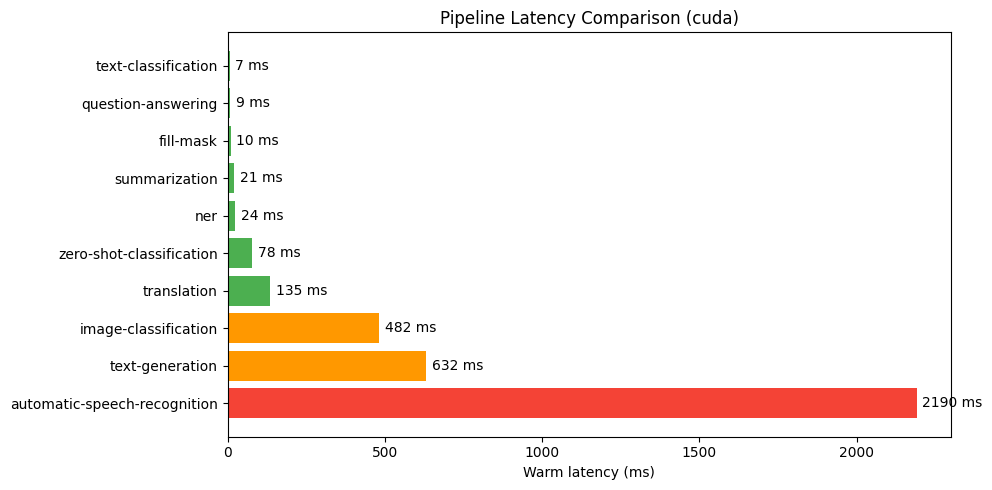

Chart saved to results/benchmark_chart.png


In [104]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#4CAF50" if ms < 200 else "#FF9800" if ms < 1000 else "#F44336"
          for ms in df["warm_latency_ms"]]
bars = ax.barh(df["task"], df["warm_latency_ms"], color=colors)
ax.bar_label(bars, fmt="%.0f ms", padding=4)
ax.set_xlabel("Warm latency (ms)")
ax.set_title(f"Pipeline Latency Comparison ({DEVICE})")
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("../results/benchmark_chart.png", dpi=120, bbox_inches="tight")
plt.show()
print("Chart saved to results/benchmark_chart.png")

In [105]:
# Save benchmark results
import os
os.makedirs("../results", exist_ok=True)
df.to_csv("../results/notebook_benchmarks.csv", index=False)
print("Saved to results/notebook_benchmarks.csv")

Saved to results/notebook_benchmarks.csv


---
## Key Takeaways

1. **Encoder-only models** (DistilBERT, DistilRoBERTa) are fastest (~50–150 ms) — ideal for classification and extraction.

2. **Encoder-decoder models** (BART, MarianMT, DistilBART) are slower (~200–2000 ms) — required for generation and seq2seq tasks.

3. **Vision Transformers** (ViT) have comparable latency to text encoders — the image is simply tokenized as patches.

4. **ASR** (Whisper) is the slowest on CPU — audio requires far more computation than text.

5. **Zero-shot classification** scales linearly with label count — each label adds one NLI pass.

6. **Temperature** affects diversity but not speed in text generation — all temperatures have the same forward-pass cost.

7. **The `pipeline()` abstraction** seamlessly handles:
   - Different input types (string, dict, URL, numpy array)
   - Different output schemas per task
   - Device placement (CPU / GPU)
   - Batching and tokenization

---
*Reference*: [HuggingFace LLM Course — Chapter 1.3](https://huggingface.co/learn/llm-course/chapter1/3)